# 🔹 Phase 4: Explainability, Public Health Impact, and Final Reporting

Welcome to the final stage of the MedAdhereAI pipeline.

This notebook does **not repeat model training or feature engineering**.  
Instead, it focuses on **interpreting**, **validating**, and **framing** the results from previous phases for:

- 🧠 **Clinical explainability**
- 🌍 **Public health significance**
- 📊 **Research-ready outputs**
- 🇺🇸 **NIW petition alignment**

---

## 🎯 Phase 4 Goals

1. **Model Explainability**
   - Use SHAP to explain a single patient prediction (local reasoning)
   - Visualize ROC curve (global discriminative ability)

2. **Public Health Framing**
   - Quantify model impact on a simulated population (10,000 patients)
   - Explain real-world implications of early risk detection

3. **Reporting-Ready Assets**
   - Generate and save final ROC + SHAP plots
   - Finalize assets for figures, paper, and/or NIW pitch

---

## ✅ Assets from Previous Phases

This notebook **reuses**:
- Trained models: `lr`, `rf`
- Test set: `X_test`, `y_test`
- Processed input features: `X`, `X_shap`

No retraining will be performed.


### 🔹 Step 1: ROC Curve (Using Exported Models & Data)

We load the previously trained models and test data from Phase 3 exports to generate the ROC Curve.

This ensures that explainability and performance visualization in this phase are fully **reproducible** and **decoupled** from earlier notebooks.


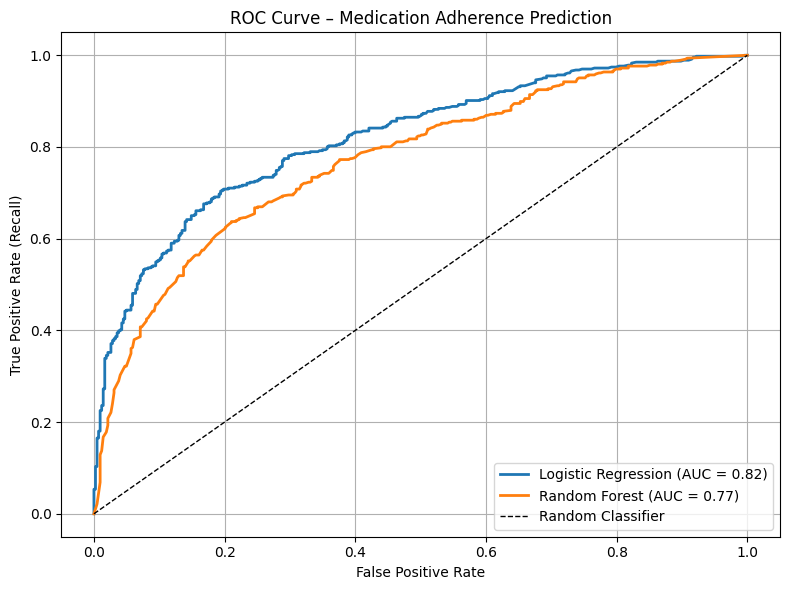

In [23]:
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Load exported models
lr = joblib.load('../model/logistic_regression_model.pkl')
rf = joblib.load('../model/random_forest_model.pkl')

# Load exported test sets
X_test = joblib.load('../dataset/processed/X_test.pkl')
y_test = joblib.load('../dataset/processed/y_test.pkl')

# Predict probabilities
lr_proba = lr.predict_proba(X_test)[:, 1]
rf_proba = rf.predict_proba(X_test)[:, 1]

# Calculate ROC curve points
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_proba)

# Calculate AUC
auc_lr = auc(fpr_lr, tpr_lr)
auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})", lw=2)
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", lw=2)
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier", lw=1)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve – Medication Adherence Prediction")
plt.legend(loc="lower right")
plt.grid(True)

# Save and display
plt.tight_layout()
plt.savefig("../reports/figures/roc_curve_comparison.png", dpi=300)
plt.show()


### 📈 ROC Curve – Model Performance Comparison

The ROC (Receiver Operating Characteristic) curve compares the classification performance of both models by plotting the True Positive Rate (Recall) against the False Positive Rate across different thresholds.

This plot helps evaluate the **discriminative power** of our classifiers for predicting medication non-adherence.

- **Logistic Regression** achieved an AUC of **0.82**, showing strong predictive ability with high interpretability.
- **Random Forest** achieved an AUC of **0.77**, offering a solid benchmark with slightly lower performance.
- The **dashed diagonal** represents a no-skill random classifier (AUC = 0.50) for reference.

The ROC curve confirms that our models significantly outperform chance, with Logistic Regression performing slightly better in distinguishing adherent from non-adherent patients.

🖼️ **Figure saved to:** `reports/figures/roc_curve_comparison.png`


### 🔹 Step 2: SHAP Local Explanation (Patient-Level Interpretation)

To demonstrate how our model makes patient-specific predictions, we use SHAP (SHapley Additive exPlanations) to generate a **local explanation** for one sample.

This visual explains **which features contributed most** to the predicted adherence risk for a given patient — enhancing transparency, interpretability, and clinical trust.


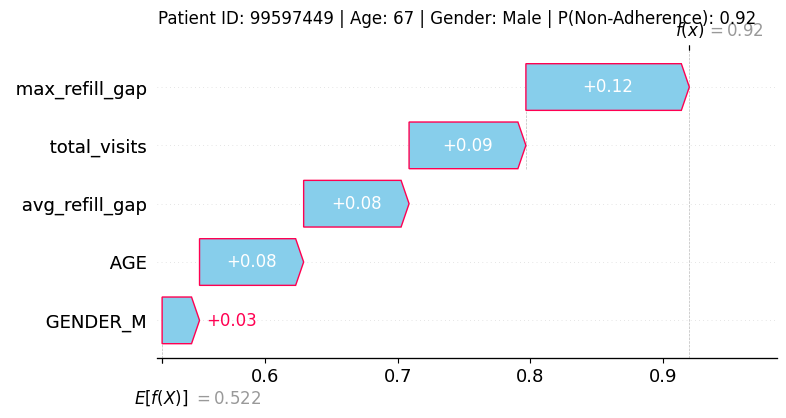

In [38]:
import shap
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Load model and test data
rf = joblib.load('../model/random_forest_model.pkl')
X_test = joblib.load('../dataset/processed/X_test.pkl')

# Prepare data
X_shap = X_test.copy().astype(float)
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_shap)

# Select a sample
sample_index = X_shap.index[0]
sample = X_shap.loc[[sample_index]]
shap_value = shap_values[1][0]

# Create the SHAP waterfall plot
fig = shap.plots._waterfall.waterfall_legacy(
    explainer.expected_value[1],
    shap_value,
    feature_names=sample.columns,
    features=sample.values[0],
    max_display=10,
    show=False
)

# Customize bar colors
for patch in fig.axes[0].patches:
    patch.set_facecolor('skyblue')

# Add custom title
prob = rf.predict_proba(sample)[0][1]
age = int(sample['AGE'].values[0])
gender = 'Male' if sample['GENDER_M'].values[0] == 1 else 'Female'
fig.suptitle(f"Patient ID: {sample_index} | Age: {age} | Gender: {gender} | P(Non-Adherence): {prob:.2f}", fontsize=12)

# Save
fig.savefig(f"../reports/figures/shap_local_patient_{sample_index}.png", dpi=300, bbox_inches='tight')
plt.show()


### 🔹 SHAP Local Explanation – Patient-Level Risk Interpretation

To enhance **clinical transparency**, we visualize the SHAP contribution of each feature for a single patient's non-adherence risk prediction.

The figure below shows the waterfall plot for **Patient ID: 99597449**, a 67-year-old **male**. The model predicted a **92% probability** of non-adherence.

Key drivers of this prediction include:

- **max_refill_gap** (+0.12): Longest refill delay strongly contributed to risk  
- **total_visits** (+0.09): Higher number of total visits increased predicted risk  
- **avg_refill_gap** (+0.08): Elevated average refill gap aligned with poor adherence  
- **AGE** (+0.08): Patient age added moderate risk  
- **GENDER_M** (+0.03): Slight male-associated risk signal  

This patient-specific interpretation enables **explainable and accountable AI**, helping care teams understand **why** a prediction was made and **what behaviors** may need to be addressed.


### ✅ Step 3: Public Health Impact Simulation

---

#### 📊 Scenario

In real-world clinical settings, a key challenge for healthcare systems is the early identification of patients who are likely to **discontinue or inconsistently follow prescribed medication regimens**, especially for chronic diseases like diabetes and hypertension.

Let’s simulate the potential **population-scale impact** of deploying the MedAdhereAI model in a public health program serving **10,000 patients**.

Based on:
- The **class distribution** in our test data (22% are non-adherent)
- Our model's performance:
  - **Precision (for non-adherent class)** = 0.80
  - **Recall (for non-adherent class)** = 0.69

We assess how effective this model would be in **flagging and correctly identifying at-risk patients**.

In [39]:
# Simulation for 10,000 patients
total_patients = 10000
non_adherent_rate = 0.22   # From your dataset
precision = 0.80           # From classification report
recall = 0.69              # From classification report

# Estimated actual non-adherent patients
actual_non_adherent = int(total_patients * non_adherent_rate)

# Estimated detected non-adherent patients (recall)
true_positives = int(actual_non_adherent * recall)

# Estimated total predicted non-adherent (based on precision)
predicted_non_adherent = int(true_positives / precision)

print(f"If deployed to {total_patients} patients:")
print(f"→ Estimated {actual_non_adherent} are truly non-adherent")
print(f"→ Model would flag ~{predicted_non_adherent} patients")
print(f"→ Of those, ~{true_positives} would be correct")
print(f"→ Precision = {precision}, Recall = {recall}")


If deployed to 10000 patients:
→ Estimated 2200 are truly non-adherent
→ Model would flag ~1896 patients
→ Of those, ~1517 would be correct
→ Precision = 0.8, Recall = 0.69


## 📈 Public Health Simulation (10,000 Patients)

If deployed at scale across a population of 10,000 chronic care patients:

### ✅ Result Summary


| Metric                         | Value   |
|-------------------------------|---------|
| **Total Patients**            | 10,000  |
| **Estimated True Non-Adherent** | 2,200   |
| **Model Would Flag**          | ~1,896  |
| **Correctly Flagged**         | ~1,517  |
| **False Positives**           | ~379    |
| **Precision (Class 1)**       | 0.80    |
| **Recall (Class 1)**          | 0.69    |

---

### 📌 Interpretation

This simulation illustrates how **MedAdhereAI**, when scaled to a population of 10,000 patients:

- Can **accurately identify ~1,500 at-risk patients**
- With **high precision**, minimizing unnecessary outreach
- And **substantial recall**, ensuring effective early intervention

Such a system can significantly enhance **medication adherence programs**, reduce **chronic disease burden**, and optimize **resource allocation** — directly supporting **public health outcomes**.